In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [5]:
def SUMP_factor(df, n=20):
    """
    计算 SUMP 因子
    SUMP = Sum(Greater(close - Ref(close, 1), 0), n) / (Sum(Abs(close - Ref(close, 1)), n) + 1e-12)
    
    参数:
    df: 包含OHLCV数据的DataFrame
    n: 滚动窗口大小 (默认20)
    """
    df = df.copy()
    
    # 计算价格变化
    df['delta_close'] = df['close'].diff(1)
    
    # 计算 Greater(delta_close, 0)，即正价格变化
    df['gain'] = df['delta_close'].where(df['delta_close'] > 0, 0)
    
    # 计算 Abs(delta_close)，即价格变化的绝对值
    df['abs_delta'] = df['delta_close'].abs()
    
    # 计算滚动窗口内的总和
    sum_gain = df['gain'].rolling(n).sum()
    sum_abs_delta = df['abs_delta'].rolling(n).sum()
    
    # 计算 SUMP 因子
    factor = sum_gain / (sum_abs_delta + 1e-12)
    
    return factor

# 因子测试

In [10]:
evaluator.set_factor(
    factor_func=lambda df: SUMP_factor(df, n=30),
    factor_name='SUMP_20'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.014239
   Rank_IC (Spearman): -0.029681
📊 信息比率:
   IR: 0.156683
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130690
   因子列: SUMP_20
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


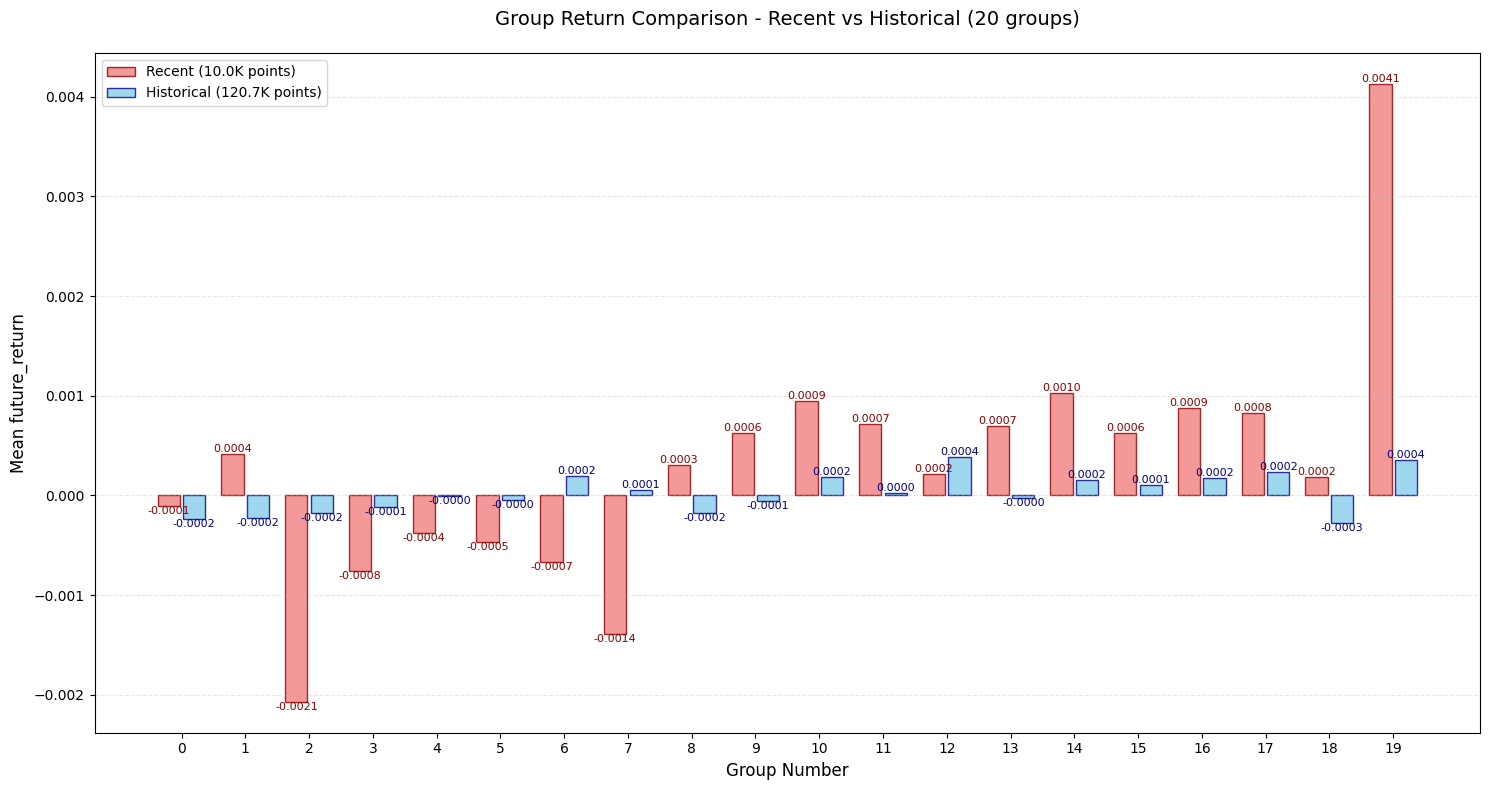

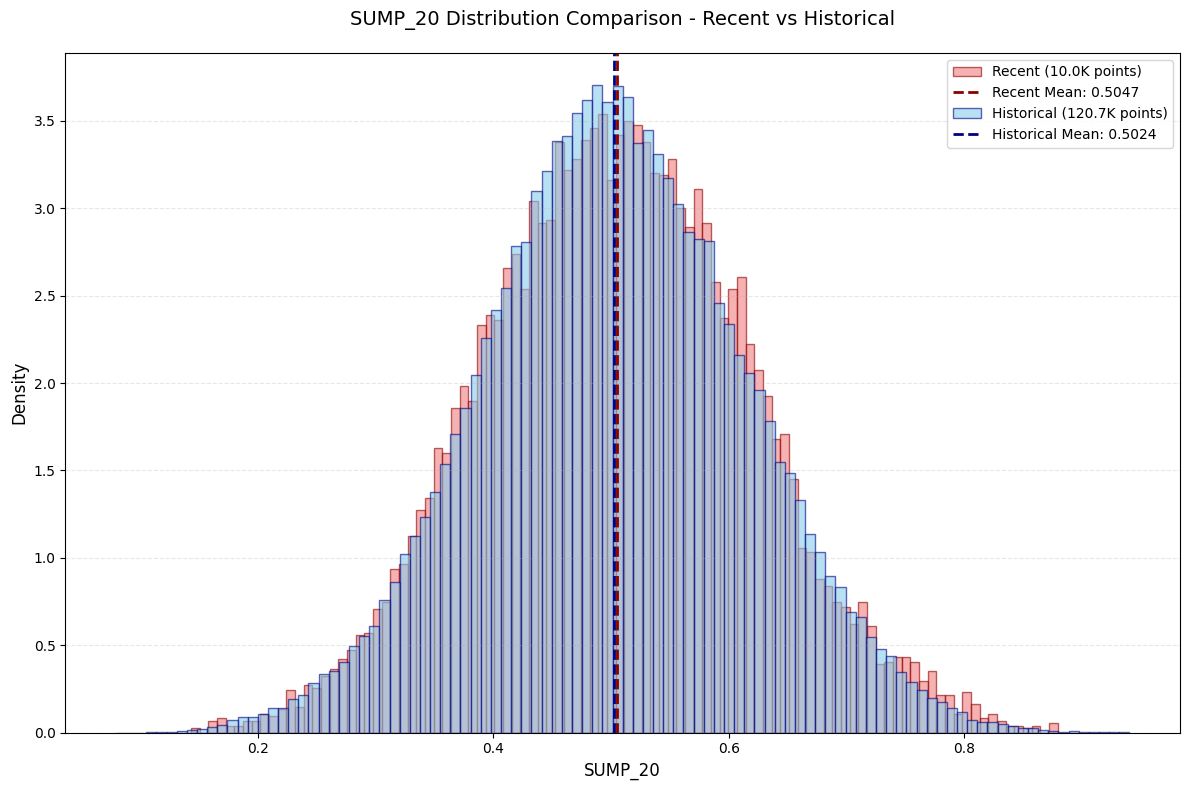

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [11]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)